In [7]:
import matplotlib.pyplot as plt 
%matplotlib inline

import networkx as nx  # Library for hanling graphs (please check 4_Introduction_Graph)
import random # possibility to create random numbers (The "P" in PRM)
import numpy as np
import math

from IPPerfMonitor import IPPerfMonitor

# sort nearest neighbour brute force
import heapq
import copy
# reduce coding effort by using function provided by scipy
from scipy.spatial.distance import euclidean

In [8]:
def inSameConnectedComponent(node1, node2, graph):
    """ Check whether to nodes are part of the same connected component using
        functionality from NetworkX
    """
    for connectedComponent in nx.connected_components(graph):
        if (node1 in connectedComponent) & (node2 in connectedComponent):
            return True
        
    return False

In [9]:

def nearestNeighboursX(pos, graph, radius):
    """ Brute Force method to find all nodes of a 
    graph near the given position **pos** with in the distance of
    **radius** in **increasing order**"""
    
    heap = list()
    for node in graph.nodes(data=True): # using (data=True) will generate a list of nodes with all attributes
        if euclidean(node[1]['pos'],pos) < radius:
            # use a heap-queue to sort the nodes in increasing order
            heapq.heappush(heap, (euclidean(node[1]['pos'] ,pos), node))
            #if len(heap) > 2 :
            #    break

    result = list()
    while len(heap) > 0 :
         result.append(heapq.heappop(heap)) 
    
    return result
            
            

In [10]:
import random #Twt

def simple_Gaus_Sampling(collChecker):
    
    #Get the limites for the graph 
    limits = collChecker.getEnvironmentLimits()   
    #Get a random position within the limits    
    pos = [random.uniform(limit[0],limit[1]) for limit in limits]
    #If selected Configuration is not free pick the Point 
    if not collChecker.pointInCollision(pos):
        return False 
    #get a distance for the second Point over a gaussian distribution 
    d=np.random.normal(1,0.5)
    pos_x=pos[0]
    pos_y=pos[1]
    #get a random angle between 0 and 360 
    alpha=random.uniform(0,360)*(math.pi/180)
    #calculate the new Point with the random angle and the selected distance d 
    pos2_x=d*math.cos(alpha)+pos_x
    pos2_y=d*math.sin(alpha)+pos_y
    #store the Point 
    pos2=[pos2_x,pos2_y]
    #check if the Point is collision free 
    if collChecker.pointInCollision(pos2):
        return False
    #if the point is  collision free return it 
    return pos2

    

    

In [19]:
def normal_Gaus_Sampling(collChecker):
    
    #Get the limites for the graph 
    limits = collChecker.getEnvironmentLimits()   
    #Get a random position within the limits    
    pos = [random.uniform(limit[0],limit[1]) for limit in limits]
    #get a distance for the second Point over a gaussian distribution 
    d=np.random.normal(1,0.1)
    pos_x=pos[0]
    pos_y=pos[1]
    #get a random angle between 0 and 360 
    alpha=random.uniform(0,360)*(math.pi/180)
    #calculate the new Point with the random angle and the selected distance d 
    pos2_x=d*math.cos(alpha)+pos_x
    pos2_y=d*math.sin(alpha)+pos_y
    #store the Point 
    pos2=[pos2_x,pos2_y]
    #check if the first Point is in collision and the secon ist collision free 
    if not collChecker.pointInCollision(pos2) and collChecker.pointInCollision(pos):
        return pos2
    #check if the second Point is in collision and the first is collision free 
    if not collChecker.pointInCollision(pos) and collChecker.pointInCollision(pos2):
        return pos
    #if none of the both above conditions is true return False 
    return False


In [18]:
def agressiv_Gaussian_sampling(collChecker):
    
    limits = collChecker.getEnvironmentLimits()
    pos = [random.uniform(limit[0], limit[1]) for limit in limits]

    # get a colliding point
    for t in range(0, 10):
        while not collChecker.pointInCollision(pos):
            pos = [random.uniform(limit[0], limit[1]) for limit in limits]

        # store the x and y value of the colliding point
        pos_x = pos[0]
        pos_y = pos[1]

        # find a non colliding point in a given distance to point a
        for i in range(0, 50):
            # get a distance over a gaussian distribution
            # me,sigma = 0,1 #Mean value of the gaussian distribution, standard deviation
            d = np.random.normal(1, 1)
            angle_list = [0, 2*math.pi]
            for n in range(8):
                templist = copy.deepcopy(angle_list)
                new_angles_list = []
                verschoben = 1 
                for idx in range(len(templist)-1):
                    new_angle = (templist[idx]+templist[idx+1])/2
                    new_angles_list.append(new_angle)
                    angle_list.insert(idx+verschoben, new_angle)
                    verschoben += 1
                for alpha in new_angles_list:
                    pos2_x = d*math.cos(alpha)+pos_x
                    pos2_y = d*math.sin(alpha)+pos_y
                    pos2 = [pos2_x, pos2_y]
                    # return point when collision free
                    if not collChecker.pointInCollision(pos2):
                        return pos2

    return False

In [12]:
def learnRoadmapNearestNeighbour(graph, dim, radius, numNodes, collisionChecker):
    i = 1
    while i < numNodes:
        
        # Generate a 'randomly chosen, free configuration'
        pos = False
        num_loops = 0
        while pos==False:
            num_loops += 1
            pos = normal_Gaus_Sampling(collisionChecker)

            if num_loops > 200:
                break
        if pos is not False:
            # Find set of candidates to connect to sorted by distance
            result = nearestNeighboursX(pos, graph, radius)
            
            # check connection
            graph.add_node(i, pos=pos)
        """
        for idx, data in enumerate(result):
            if not inSameConnectedComponent(i,data[1][0],graph):
                if not collisionChecker.lineInCollision(pos,data[1][1]['pos']):
                    graph.add_edge(i,data[1][0])
        """           
        i+=1


In [13]:
def findPath(graph, start, goal,collisionChecker):
    # find nearest, collision-free connection between node on graph and start
    result = nearestNeighboursX(start, graph, radius)
    for node in result:
        if not collisionChecker.lineInCollision(start,node[1][1]['pos']):
            graph.add_node("start", pos=start)
            graph.add_edge("start",node[1][0])
            break;
    # find nearest, collision-free connection between node on graph and goal
    result = nearestNeighboursX(goal, graph, radius)
    
    for node in result:
        if not collisionChecker.lineInCollision(goal,node[1][1]['pos']):
            graph.add_node("goal", pos=goal)
            graph.add_edge("goal",node[1][0])
            break;
    # find shortest path on graph
    path = nx.shortest_path(graph,"start","goal")
    # return nodelist
    return path
    

In [14]:
def basicPRMVisualize(graph, collChecker, solution, nodeSize=300.0, ax=None):
    # get a list of posiations of all nodes by returning the content of the attribute 'pos'
    pos = nx.get_node_attributes(graph,'pos')
    
    # draw graph (nodes colorized by degree)
    nx.draw_networkx_nodes(graph, pos,  cmap=plt.cm.Blues, ax = ax, node_size=nodeSize)
    """
    nx.draw_networkx_edges(graph,pos,
                                ax = ax
                                )
    """
   
    
    #Auskommentiert für Aufgabenstellung 1
    #collChecker.drawObstacles(ax)
    
    
    # draw nodes based on solution path
    Gsp = nx.subgraph(graph,solution)
    nx.draw_networkx_nodes(Gsp,pos,
                            node_size=300,
                             node_color='g',  ax = ax)
        
    # draw edges based on solution path
    #nx.draw_networkx_edges(Gsp,pos,alpha=0.8,edge_color='g',width=10,  ax = ax)
        
    # draw start and goal
    """"
    if "start" in graph.nodes(): 
        nx.draw_networkx_nodes(graph,pos,nodelist=["start"],
                                   node_size=300,
                                   node_color='#00dd00',  ax = ax)
    if "goal" in graph.nodes():
        nx.draw_networkx_nodes(graph,pos,nodelist=["goal"],
                                   node_size=300,
                                   node_color='#DD0000', ax = ax)
    """
    

In [15]:
import importlib
import IPTestSuite

importlib.reload(IPTestSuite)

dim=2

In [16]:
for benchmark in IPTestSuite.benchList:
    print(benchmark.name)

Trap
Bottleneck
Fat bottleneck
Spirals
Entrance
Entrances
KIT
Inside
SSL
Ring
Hemispheres
Hammerhead
Zigzag
Spiral
medium
medium2
L-square
Teeth
Gearshift
Squares_easy
Zigzag_medium
Zigzag_hard
Japan
Haystack
HairPerson


Planning:  Entrances
pointInCollision- Aufrufe 3506
Failed No path between start and goal.
Planning:  KIT
pointInCollision- Aufrufe 5901
Failed Either source start or target goal is not in G
Planning:  Inside
pointInCollision- Aufrufe 2820
Failed No path between start and goal.
Planning:  SSL
pointInCollision- Aufrufe 4498
Failed No path between start and goal.
Planning:  Ring
pointInCollision- Aufrufe 9549
Failed No path between start and goal.


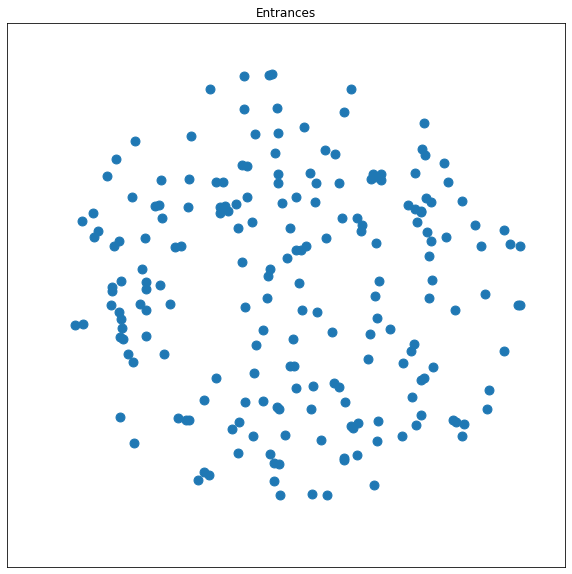

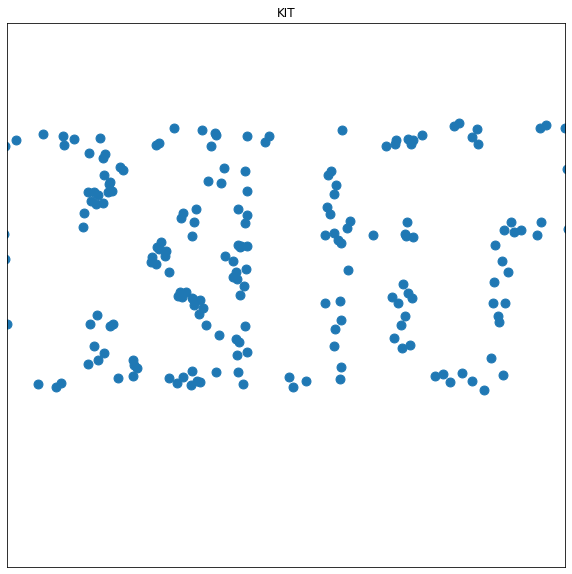

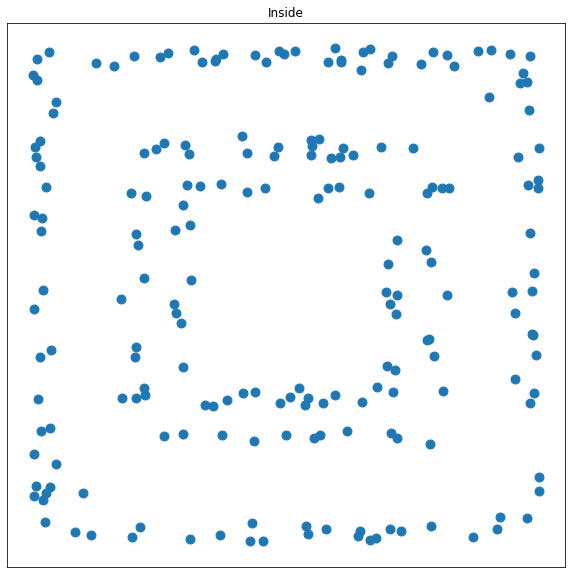

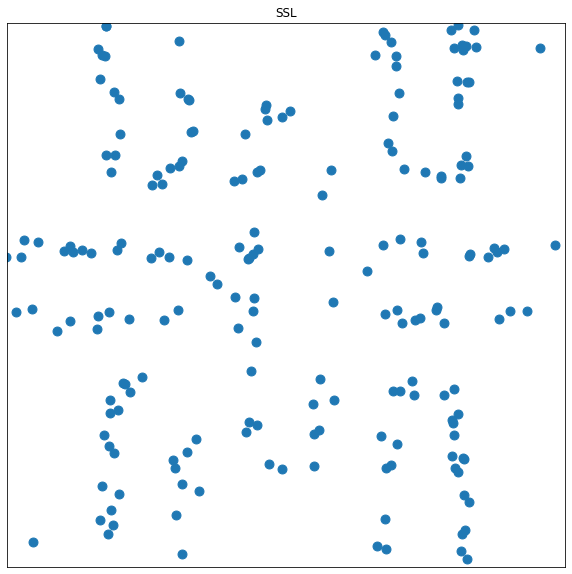

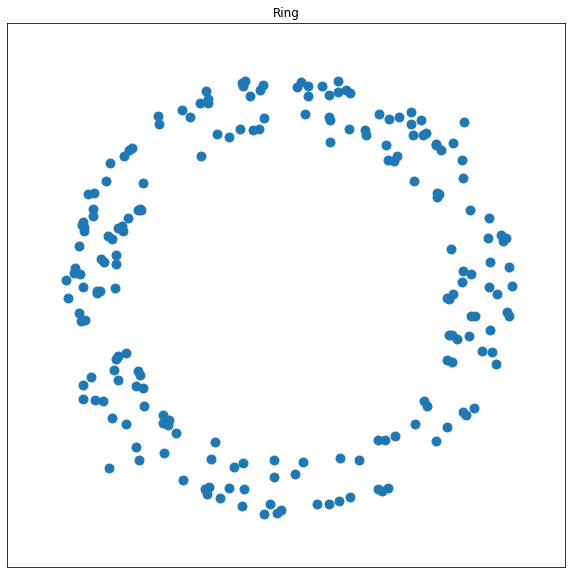

In [17]:
temp_list=IPTestSuite.benchList[5:10]

for benchmark in temp_list:
    try:
        print ("Planning: ", benchmark.name)
        collChecker = benchmark.collisionChecker
        G = nx.Graph()
        radius = 3.0
        numNodes = 200

        IPPerfMonitor.clearData()        
        learnRoadmapNearestNeighbour(G, dim, radius, numNodes, collChecker)

        Function_infos = IPPerfMonitor.dataFrame()
        counts_for_collision = len(Function_infos[Function_infos["name"]=="pointInCollision"])
        print("pointInCollision- Aufrufe", counts_for_collision)

        
        solution = findPath(G,benchmark.startList[0],benchmark.goalList[0], collChecker)
        print(solution, len(solution))
        print(len(G.nodes()))
        
    except Exception as e:
        solution = []
        print ("Failed", e)
    # draw the planning
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    limits=collChecker.getEnvironmentLimits()
    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])
    ax.set_title(benchmark.name)
    basicPRMVisualize(G,collChecker,solution,nodeSize=80,ax=ax)